In [6]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt

import time
import pickle

import MOODS.parsers
import MOODS.tools
import MOODS.scan

import seqlogo

# PREPROCESSING
download data from scenic and make the pwm matrices look nice! 

# SCENIC+ database matrices

In [14]:
scenic_des

,motif_id,motif_name,pwm_id,motif_description,source_name,source_version,gene_name,motif_similarity_qvalue,similar_motif_id,similar_motif_description,orthologous_identity,orthologous_gene_name,orthologous_species,description
0,c2h2_zfs__M1843,M1843,c2h2_zfs__M1843,ENSG00000177932,c2h2_zfs,0.90,ZNF354C,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
1,c2h2_zfs__M2430,M2430,c2h2_zfs__M2430,ENSG00000118922,c2h2_zfs,0.90,KLF12,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
2,metacluster_34.1,M3269,c2h2_zfs__M3269,ENSG00000166478,c2h2_zfs,0.90,ZNF143,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
3,c2h2_zfs__M3383,M3383,c2h2_zfs__M3383,ENSG00000043355,c2h2_zfs,0.90,ZIC2,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
4,metacluster_65.13,M3800,c2h2_zfs__M3800,ENSG00000171606,c2h2_zfs,0.90,ZNF274,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22348,transfac_public__M00532,M00532,transfac_public__M00532,V$RP58_01: RP58,transfac_public,7.0,ZBTB18,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
22349,metacluster_71.11,M00538,transfac_public__M00538,V$HTF_01: HTF (XBP1),transfac_public,7.0,XBP1,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
22350,metacluster_57.3,M00539,transfac_public__M00539,V$ARNT_02: Arnt,transfac_public,7.0,ARNT,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated
22351,metacluster_198.2,M00615,transfac_public__M00615,V$MYCMAX_03: c-Myc:Max,transfac_public,7.0,MAX,0.0,NaN,NaN,1.0,NaN,NaN,gene is directly annotated


In [7]:
scenic_des = pd.read_csv('./scenic_tfs/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl', sep = '\t')
scenic_des = scenic_des[scenic_des['description'] == 'gene is directly annotated']
scenic_des.rename(columns={'#motif_id': 'motif_id'}, inplace=True)
pwm_id = scenic_des.source_name + '__' + scenic_des.motif_name  # assuming that pwm_id is generated this way in scenic
scenic_des.insert(2, 'pwm_id', pwm_id)
scenic_des.reset_index(inplace = True, drop = True)

/scratch/320415.1.ood/ipykernel_2148148/2980758988.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  scenic_des = pd.read_csv('./scenic_tfs/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl', sep = '\t')


In [8]:
# genome_fasta_path = './data/dm6_genome/GCF_000001215.4_Release_6_plus_ISO1_MT_genomic.fna'
motif_pwms_directory_from_scenic = './scenic_tfs/v10nr_clust_public/singletons/'

filenames = os.listdir(motif_pwms_directory_from_scenic)
pwm_names_from_files = list()
pfm_matrices = dict()


for filename in os.listdir(motif_pwms_directory_from_scenic):
    with open(motif_pwms_directory_from_scenic + filename, 'r') as fin:
        matrix = list()
        
        for line in fin:
            if line.startswith('>'):
                pwm_names_from_files.append(line.strip()[1:])
                if len(matrix) != 0:
                    pfm_matrices[pwm_name] = matrix
                    matrix = list()
                pwm_name = line.strip()[1:]
            else:
                matrix.append(list(map(float, line.strip().split())))

    pfm_matrices[pwm_name] = np.array(np.array(matrix))


In [9]:
gene_to_pwm = {gene:list() for gene in scenic_des['gene_name'].unique()}
stranges = list()
no_hit = list()

for gene, tbl in scenic_des.groupby('gene_name'):
    for pwm_name in tbl['pwm_id'].values:
        if pwm_name in pwm_names_from_files:
            gene_to_pwm[gene].append(pwm_name)
        else:
            stranges.append((gene, pwm_name))

    if len(gene_to_pwm[gene]) == 0:
        no_hit.append(gene)

print('Genes with no Pwm matrix assigned:')
print(no_hit)

Genes with no Pwm matrix assigned:
['ABL1', 'AEBP2', 'AHDC1', 'APEX1', 'ARID5A', 'ARNTL2', 'BANP', 'BCLAF1', 'BDP1', 'BRF1', 'CARF', 'CCNT2', 'CENPBD1', 'CNOT3', 'CRTC2', 'CTBP1', 'CTNNB1', 'CXXC5', 'DBX1', 'DEAF1', 'DIDO1', 'DNMT1', 'DNTTIP1', 'DPF2', 'EBF2', 'EBF4', 'EWSR1', 'FIZ1', 'FOXD4L1', 'FOXD4L3', 'FOXD4L4', 'FOXD4L5', 'FOXD4L6', 'FOXE3', 'FOXN4', 'FOXR1', 'GPBP1L1', 'GTF2A1', 'GTF2A1L', 'GTF2A2', 'HDAC1', 'HDAC2', 'HELT', 'HMGXB3', 'HNRNPUL1', 'IKZF4', 'ILF3', 'IRX1', 'KDM2B', 'KMT2A', 'LCOR', 'MLLT10', 'MTERF1', 'NCOA2', 'NFE4', 'NONO', 'OVOL3', 'PARP1', 'PEG3', 'POLR3A', 'POU2AF1', 'PRDM12', 'PRDM13', 'PRDM15', 'PRDM16', 'PRDM5', 'RB1', 'RHOXF2B', 'RLF', 'SALL1', 'SALL2', 'SALL3', 'SATB2', 'SFPQ', 'SMAD6', 'SMAD7', 'SMAD9', 'SP6', 'SP7', 'TBPL2', 'TBX10', 'TBX22', 'TERF1', 'TET1', 'TFDP2', 'TRAF4', 'TRIM28', 'ZBTB1', 'ZBTB24', 'ZBTB34', 'ZBTB38', 'ZBTB39', 'ZBTB41', 'ZBTB47', 'ZBTB5', 'ZBTB8B', 'ZFP2', 'ZFP30', 'ZFP62', 'ZFP92', 'ZFPM1', 'ZFY', 'ZHX1', 'ZKSCAN4', 'ZNF107', 

In [13]:
len(gene_to_pwm), len(pfm_matrices)

(1495, 17995)

In [5]:


# function from Osya
def create_pwm(freq_matrix: np.array,
               nucl_frequencies: np.array = np.full(4, 0.25),  # A C G T
               indices: 'np.array | None' = None) -> np.array:
    
    assert nucl_frequencies.sum() == 1, "not frequencies"
    if indices is not None:
        freq_matrix = freq_matrix[:, indices]
    bg_matrix = np.repeat(nucl_frequencies[:, np.newaxis], freq_matrix.shape[1], axis=1)
    energy_matrix = -np.log(freq_matrix / bg_matrix)
    energy_matrix -= energy_matrix.min(axis=0)  # 0 corresponds to the consensus sequence
    return -energy_matrix


def create_log_odds(freq_matrix: np.array,
               nucl_frequencies: np.array = np.full(4, 0.25)):  # A C G T:

    bg_matrix = np.repeat(nucl_frequencies[:, np.newaxis], freq_matrix.shape[1], axis=1)
    
    ps = 0.001
    logodds = np.log((freq_matrix + ps*bg_matrix)/freq_matrix.sum(axis = 0)) - np.log(bg_matrix)

    return logodds


def get_pwm_matrix(pfm):
    # try1
    pfm = np.array(pfm)
    pfm = pfm.T
    freq_matrix = np.array(pfm)
    freq_matrix = (freq_matrix/freq_matrix.sum(axis = 0))

    freq_matrix[freq_matrix == 0] += 0.001 # 0.001 is the psuedocount
    pwm = create_pwm(freq_matrix)
    return pwm



In [6]:
pwm_matrices = dict()
for name, matrix in pfm_matrices.items():
    pwm_matrices[name] = get_pwm_matrix(matrix)


# now let's add puffin


To download into the puffin_motifs folder

```
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/CREB_motif.txt
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/ETS_motif.txt
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/Long_Inr_motif.txt
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/NFY_motif.txt
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/NRF1_motif.txt
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/SP_motif.txt
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/TATA_motif.txt
wget 'https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/U1 snRNP_motif.txt'
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/YY1_motif.txt
wget https://raw.githubusercontent.com/jzhoulab/puffin/refs/heads/main/Puffin_motifs_and_motif_effects/ZNF143_motif.txt
```

In [7]:
puffin_motif_names = ['CREB', 'ETS', 'Long_Inr', 'NFY', 'NRF1', 'SP', 'TATA', 'U1_snRNP', 'YY1', 'ZNF143']
# puffin_pwm_names = [f'puffin_{name}' for name in puffin_motif_names]

for mf in puffin_motif_names:
    temp = pd.read_csv(f'./puffin_motifs/{mf}_motif.txt', sep = ' ')
    temp = temp.drop(columns = ['Unnamed: 0'])
    pwm_from_puffin = temp.values
    pwm_from_puffin -= pwm_from_puffin.min(axis=0)
    pwm_from_puffin = -pwm_from_puffin
    
    pwm_matrices[f'puffin_{mf}'] = pwm_from_puffin
    gene_to_pwm[f'puffin_{mf}'] = [f'puffin_{mf}']

### Saving

In [8]:
tt= time.time()
with open('gene_to_pwm_dict.pickle', "wb") as output_file:
    pickle.dump(gene_to_pwm, output_file)
print(time.time() - tt)


tt= time.time()
with open('pwm_matrices_for_moods.pickle', "wb") as output_file:
    pickle.dump(pwm_matrices, output_file)
print(time.time() - tt)

0.006644010543823242
0.16919398307800293


### precalculate thresholds

In [11]:

pvalue = 0.001
bg = MOODS.tools.flat_bg(4)


threshold_dict_001 = dict()
threshold_dict_0001 = dict()

for pwm_id, matrix in pwm_matrices.items():

    t = MOODS.tools.threshold_from_p(matrix, bg, 0.001)
    threshold_dict_001[pwm_id] = t

    t = MOODS.tools.threshold_from_p(matrix, bg, 0.0001)
    threshold_dict_0001[pwm_id] = t


tt= time.time()
with open('mood_thresholds_001.pickle', "wb") as output_file:
    pickle.dump(threshold_dict_001, output_file)
print(time.time() - tt)


tt= time.time()
with open('mood_thresholds_0001.pickle', "wb") as output_file:
    pickle.dump(threshold_dict_0001, output_file)
print(time.time() - tt)

0.009057998657226562
0.00560760498046875


### Select best matrix per gene

In [8]:
pfm_data = list()

for gene in gene_to_pwm:
    if gene.startswith('puffin'):
        continue
    for pwm_id in gene_to_pwm[gene]:
        m = np.array(pfm_matrices[pwm_id])
        length = m.shape[0]
        column_sum = m.sum(axis = 1).max()
        min_non0 = m[m > 0].min()
        max_non1 = m[m < column_sum*0.99999].max()
        pfm_data.append([pwm_id, gene, length, column_sum, min_non0, max_non1])

pfm_df = pd.DataFrame(pfm_data, columns=['pwm_id', 'gene', 'length', 'column_sum', 'min', 'max'])
pfm_df['closest_to_consensus'] = pfm_df['max']/pfm_df['column_sum']

Text(0, 0.5, 'pwm count')

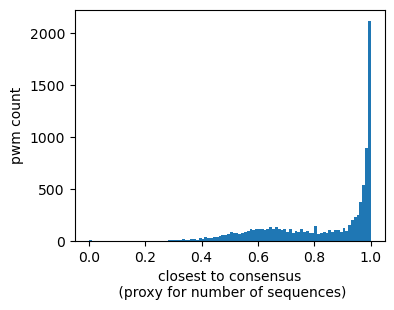

In [11]:
plt.figure(figsize = (4, 3))
plt.hist(pfm_df['closest_to_consensus'], bins = 100); 
plt.xlabel('closest to consensus\n (proxy for number of sequences)')
plt.ylabel('pwm count')

In [9]:
gene_to_unique_pwm = dict()

for gene, group in pfm_df.groupby('gene'):
    if group['column_sum'].max() <= 100:
        pwm_choice = group.sort_values('closest_to_consensus', ascending = False)['pwm_id'].values[0]
    else:
        pwm_choice = group.sort_values('column_sum', ascending = False)['pwm_id'].values[0]
    gene_to_unique_pwm[gene] = pwm_choice

for mf in puffin_motif_names:
    gene_to_unique_pwm[f'puffin_{mf}'] = f'puffin_{mf}'
        

In [149]:
gene_to_unique_pwm['puffin_CREB']

'puffin_CREB'

In [147]:
len(gene_to_unique_pwm)

1264

In [148]:
len(gene_to_pwm)

1505

In [150]:
tt= time.time()
with open('pwm_matrice_choice_per_gene.pickle', "wb") as output_file:
    pickle.dump(gene_to_unique_pwm, output_file)
print(time.time() - tt)

0.0022509098052978516


Text(0, 0.5, 'Density')

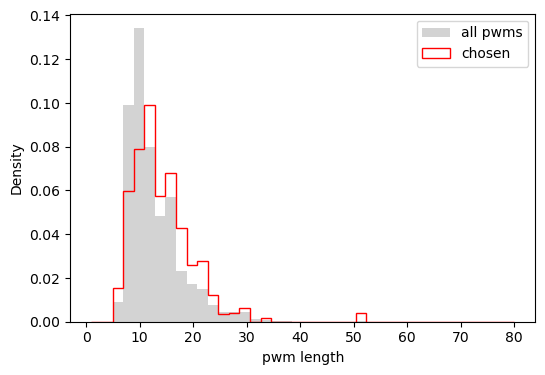

In [140]:

plt.figure(figsize = (6, 4))

lengths = [pwm_matrices[pwm_id].shape[1] for pwm_id in pwm_matrices.keys()]
plt.hist(lengths, range = (1, 80), bins = 40, histtype = 'stepfilled', density = True, color = 'lightgrey', 
label = 'all pwms'); 

lengths = [pwm_matrices[pwm_id].shape[1] for pwm_id in gene_to_unique_pwm.values()]
plt.hist(lengths, range = (1, 80), bins = 40, histtype = 'step', density = True, color = 'red', 
label = 'chosen'); 

plt.legend()
plt.xlabel('pwm length')
plt.ylabel('Density')

In [ ]:
'puffin_CREB' in 

In [146]:

lengths = [pwm_matrices[pwm_id].shape[1] for pwm_id in gene_to_unique_pwm.values()]
max(lengths)

51

## Some logo plotting

In [13]:
# plt.figure
ppms = list()


for idx, pwm_id in enumerate(gene_to_pwm['KLF12']):
    print(pwm_id)
    freq = pwm_matrices[pwm_id]
    freq /= freq.sum(axis = 0)
    ppm = seqlogo.Ppm(freq)
    ppms.append(ppm)


hocomoco__KLF12_HUMAN.H11MO.0.C
jaspar__MA0742.2
kznf__KLF12_Schmitges2016_ChIP-seq
swissregulon__hs__KLF12
taipale_cyt_meth__KLF12_NGCCGACGCCCW_FL_meth_repr
taipale_cyt_meth__KLF12_NRCCACGCCCW_FL
taipale_cyt_meth__KLF12_NRCCACGCCCW_FL_meth_repr
transfac_public__M00468


In [17]:
gene_to_unique_pwm['ZNF202']
gene_to_unique_pwm['ZNF468']

'kznf__ZNF468_Imbeault2017_RP_RCADE'

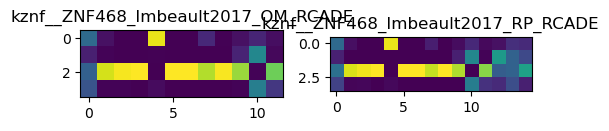

In [16]:
plt.figure(figsize=(5, 5))

ppms = list()

for idx, pwm_id in enumerate(gene_to_pwm['ZNF468']):
    plt.subplot(4, 2, idx + 1)
    freq = np.array(pfm_matrices[pwm_id]).T
    freq = freq/freq.sum(axis = 0)
    ppm = seqlogo.Ppm(freq)
    ppms.append(ppm)
    plt.imshow(freq)
    plt.title(pwm_id)

plt.tight_layout()

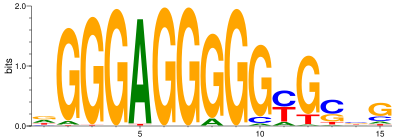

In [18]:
seqlogo.seqlogo(ppms[1], ic_scale = True, size = 'medium' , format='svg')

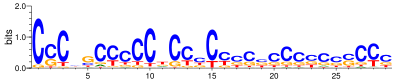

In [16]:
seqlogo.seqlogo(ppms[1], ic_scale = True, size = 'medium' , format='svg')